## CSCI 5622-073: Machine Learning Project
## Author: Nikhil B M
## University of Colorado, Boulder

### Data Collection
There are two process for data gathering. 


    1. The NYC Taxi data is collect from NYC Taxi and Limousine Commission (TLC) website: 
    https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page which is run by the government of US. The data is collect from January 2022 to June 2022. The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC)
    
    2. The weather data is obtained from Visual Crossing Weather API for the same time range. 

Importing Required Libraries

In [1]:
#!pip3 install graphviz
#!pip3 install dask
#!pip3 install toolz
#!pip install gpxpy
#!pip install folium
#!pip install keras
#!pip3 install Jinja2==3.0.3

In [1]:
import csv
import codecs
import json
import folium
import datetime
import time
import sys
import graphviz

from skimage import io
import urllib.request

import dask.dataframe as dd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline
from matplotlib import rcParams

import math
import pickle
import os

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import scipy
import pdb
import warnings
from sklearn import linear_model

warnings.filterwarnings("ignore")

### 1. API for weather Data

In [ ]:
# This is the core of our weather query URL
"""
print('Usage: FetchWeather Location Date API_KEY')
print('  Location: Please provide a location for the weatch search.')
Location = input("Location")
print('    (Make sure to use quotes if the name contains spaces.)')
print('  Date: Please specify a date in the format YYYY-MM-DD to look up weather for a specific date.')
Start_Date = input("Start Date Time")
End_Date = input("End Date Time")
print('    Or use the FORECAST to look up the current weather forcast.')
print('  API_KEY: Please specify your Visual Crossing Weather API Key')
print('    If you don\'t already have an API Key, get one at www.visualcrossing.com/weather-api.')
API_Key = input("Enter your API Key:")

print('Example: FetchWeather \"Herndon, VA\" 2006-04-12 KEY_123')
print('Example: FetchWeather \"Beverly Hills, CA\" FORECAST KEY_123')
print()

content_type = input("Enter the content Type for download in terms of CSV, JSON, EXCEL:")
Output_Select= input("Enter the frequency of the weather data in terms of Daily, Hourly, Alerts, Current, Events:")


# Build the entire query
BaseURL = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
QueryLocation = "New%20York%20City%2C%20USA"

URL = BaseURL + Location + "/" + Start_Date + "/" + End_Date + "?unitGroup=us&include=" + Output_Select + "&key=" + API_Key + "&contentType=" + content_type
#URL = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/New%20York%20City%2C%20USA/2022-01-16/2022-01-31?unitGroup=us&include=hours&key=8DNM3VXP34HZMJMBEBKG44ETZ&contentType=csv"
"""

URL =  "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/New%20York%20City%2C%20USA/2022-01-01/2022-01-15?unitGroup=us&include=hours&key=8DNM3VXP34HZMJMBEBKG44ETZ&contentType=csv"

print(' - Running query URL: ', URL)
print()

# Parse the results as CSV
CSVBytes = urllib.request.urlopen(URL)
CSVText = csv.reader(codecs.iterdecode(CSVBytes, 'utf-8'))
Location = 'New_York_City'
Start_Date = '2022-01-01'
End_Date = '20bbb22-01-15'
Output_dir = "D:/2_MS_in_DS/2nd_Semester/Machine_Learning/Project/Data/"
Output_File = Output_dir + "weather_data_"+Location+"_"+Start_Date+"_"+End_Date+".csv"

with open(Output_File, mode='w',newline='') as employee_file:
    employee_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL) 
    for Row in CSVText:
        employee_writer.writerow(Row)


### 3. Web Scraper for NYC Taxi Data

In [160]:
from bs4 import BeautifulSoup as bs
import requests

DOMAIN = ''
URL = 'https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page'
FILETYPE = '.parquet'

def get_soup(url):
    return bs(requests.get(url).text, 'html.parser')

a = input("Enter the Year and month in format YYYY-MM: ")
FILETYPE = "yellow_tripdata_"+a + FILETYPE 
for link in get_soup(URL).find_all('a'): 
    file_link = link.get('href')
    if FILETYPE in file_link:
#        print(file_link)
#        print(link)
        with open(input_dir+FILETYPE, 'wb') as file:
            response = requests.get(file_link)
            file.write(response.content)
print("Successfully downloaded the file at this location: ", input_dir+FILETYPE)            

Enter the Year and month in format YYYY-MM: 2022-09
Successfully downloaded the file at this location:  D:/2_MS_in_DS/2nd_Semester/Machine_Learning/Project/Data/NYC_Taxi_Data/yellow_tripdata_2022-09.parquet


Download NYC taxi data from: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
and store it in local


#### Information on taxis:


Yellow Taxi: Yellow Medallion Taxicabs
These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.

For Hire Vehicles (FHVs)
FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged.

Green Taxi: Street Hail Livery (SHL)
The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides.

## Data Information

In [2]:
# read the data
input_dir = "D:/2_MS_in_DS/2nd_Semester/Machine_Learning/Project/Data/NYC_Taxi_Data/"
weather_input_dir = "D:/2_MS_in_DS/2nd_Semester/Machine_Learning/Project/Data/Weather_Data/"

nyc_taxi_Jan_2022 = pd.read_parquet(input_dir+"yellow_tripdata_2022-01.parquet")
#nyc_taxi_Feb_2022 = pd.read_parquet(input_dir+"yellow_tripdata_2022-02.parquet")
#nyc_taxi_Mar_2022 = pd.read_parquet(input_dir+"yellow_tripdata_2022-03.parquet")
#nyc_taxi_Apr_2022 = pd.read_parquet(input_dir+"yellow_tripdata_2022-04.parquet")
#nyc_taxi_May_2022 = pd.read_parquet(input_dir+"yellow_tripdata_2022-05.parquet")
#nyc_taxi_Jun_2022 = pd.read_parquet(input_dir+"yellow_tripdata_2022-06.parquet")


m1 = dd.read_parquet(input_dir+"yellow_tripdata_2022-01.parquet")


In [4]:
taxi_loc = pd.read_csv('D:/2_MS_in_DS/2nd_Semester/Machine_Learning/Project/Data/taxi+_zone_lookup.csv')

## 1. NYC Taxi Data

In [5]:
nyc_taxi_Jan_2022.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [6]:
taxi_loc.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


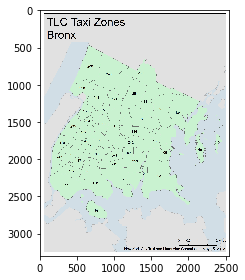

In [7]:
img = io.imread("D:/2_MS_in_DS/2nd_Semester/Machine_Learning/Project/Data/taxi_zone_map_bronx.jpg")
io.imshow(img)

In [8]:
print(nyc_taxi_Jan_2022.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')


## Features in the dataset:
<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>

	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

# Data Cleaning
In this section we will be doing univariate analysis and removing outlier,illegitimate values, missing values etc which may be caused due to some error.

In [9]:
nyc_taxi_Jan_2022.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


#### Checking the data types:

In [10]:
nyc_taxi_Jan_2022.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

## 1.a. Check for Missing Values. 


Below, we have displayed in the form of percentages. 

In [11]:
(nyc_taxi_Jan_2022.isnull().sum())/(nyc_taxi_Jan_2022.shape[0]) * 100

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          2.901989
trip_distance            0.000000
RatecodeID               2.901989
store_and_fwd_flag       2.901989
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     2.901989
airport_fee              2.901989
dtype: float64

Roughly, around 3% of data has missing values. From the below, we can see that the same records have missing values. So we can drop them. 

In [12]:
nyc_taxi_Jan_2022[nyc_taxi_Jan_2022['passenger_count'].isna()].head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2392428,2,2022-01-01 00:50:00,2022-01-01 00:54:00,NaN,1.00,NaN,None,68,246,0,13.20,0.0,0.5,1.75,0.0,0.3,18.25,NaN,NaN
2392429,2,2022-01-01 00:49:24,2022-01-01 01:27:36,NaN,13.31,NaN,None,257,223,0,44.87,0.0,0.5,10.05,0.0,0.3,55.72,NaN,NaN
2392430,2,2022-01-01 00:42:00,2022-01-01 00:56:00,NaN,2.87,NaN,None,143,236,0,13.23,0.0,0.5,3.51,0.0,0.3,20.04,NaN,NaN
2392431,2,2022-01-01 00:40:00,2022-01-01 00:55:00,NaN,3.24,NaN,None,143,262,0,14.19,0.0,0.5,3.72,0.0,0.3,21.21,NaN,NaN
2392432,2,2022-01-01 00:40:00,2022-01-01 00:52:00,NaN,2.19,NaN,None,239,166,0,13.20,0.0,0.5,5.25,0.0,0.3,21.75,NaN,NaN
2392433,1,2022-01-01 00:18:10,2022-01-01 00:30:29,NaN,1.80,NaN,None,79,164,0,9.50,0.5,0.5,2.00,0.0,0.3,15.30,NaN,NaN
2392434,2,2022-01-01 00:33:22,2022-01-01 01:07:32,NaN,5.82,NaN,None,90,151,0,20.83,0.0,0.5,5.20,0.0,0.3,29.33,NaN,NaN
2392435,2,2022-01-01 00:21:00,2022-01-01 00:33:00,NaN,2.47,NaN,None,142,140,0,13.20,0.0,0.5,3.50,0.0,0.3,20.00,NaN,NaN
2392436,2,2022-01-01 00:47:03,2022-01-01 01:08:11,NaN,4.91,NaN,None,231,143,0,20.88,0.0,0.5,3.91,0.0,0.3,28.09,NaN,NaN
2392437,2,2022-01-01 00:32:00,2022-01-01 00:39:00,NaN,1.30,NaN,None,239,142,0,13.20,0.0,0.5,1.00,0.0,0.3,17.50,NaN,NaN


In [13]:
nyc_taxi_Jan_2022.dropna(inplace=True)

In [14]:
(nyc_taxi_Jan_2022.isnull().sum())/(nyc_taxi_Jan_2022.shape[0]) * 100

VendorID                 0.0
tpep_pickup_datetime     0.0
tpep_dropoff_datetime    0.0
passenger_count          0.0
trip_distance            0.0
RatecodeID               0.0
store_and_fwd_flag       0.0
PULocationID             0.0
DOLocationID             0.0
payment_type             0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.0
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.0
total_amount             0.0
congestion_surcharge     0.0
airport_fee              0.0
dtype: float64

## 1.b. Passenger_count

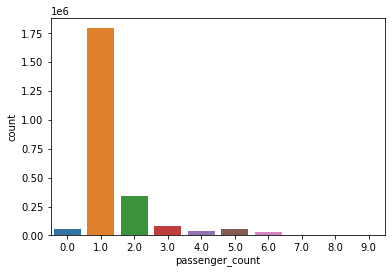

In [15]:
ax = sns.countplot(x="passenger_count",data=nyc_taxi_Jan_2022)

From the above, we can see that, we can remove the rows which contains passenger count as 0, since it don't  help in forecasting demand.

In [16]:
nyc_taxi_Jan_2022[nyc_taxi_Jan_2022['passenger_count'] == 0].count()

VendorID                 52061
tpep_pickup_datetime     52061
tpep_dropoff_datetime    52061
passenger_count          52061
trip_distance            52061
RatecodeID               52061
store_and_fwd_flag       52061
PULocationID             52061
DOLocationID             52061
payment_type             52061
fare_amount              52061
extra                    52061
mta_tax                  52061
tip_amount               52061
tolls_amount             52061
improvement_surcharge    52061
total_amount             52061
congestion_surcharge     52061
airport_fee              52061
dtype: int64

This is 2.1760% of the entire dataset. 

In [17]:
nyc_taxi_Jan_2022.shape

(2392428, 19)

In [18]:
indexAge = nyc_taxi_Jan_2022[ (nyc_taxi_Jan_2022['passenger_count'] == 0)].index
nyc_taxi_Jan_2022.drop(indexAge , inplace=True)
display(nyc_taxi_Jan_2022.shape)
nyc_taxi_Jan_2022.head(15)

(2340367, 19)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.00,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.00,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.00,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.00,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.00,0.3,30.30,2.5,0.0
5,1,2022-01-01 00:40:15,2022-01-01 01:09:48,1.0,10.30,1.0,N,138,161,1,33.0,3.0,0.5,13.00,6.55,0.3,56.35,2.5,0.0
6,2,2022-01-01 00:20:50,2022-01-01 00:34:58,1.0,5.07,1.0,N,233,87,1,17.0,0.5,0.5,5.20,0.00,0.3,26.00,2.5,0.0
7,2,2022-01-01 00:13:04,2022-01-01 00:22:45,1.0,2.02,1.0,N,238,152,2,9.0,0.5,0.5,0.00,0.00,0.3,12.80,2.5,0.0
8,2,2022-01-01 00:30:02,2022-01-01 00:44:49,1.0,2.71,1.0,N,166,236,1,12.0,0.5,0.5,2.25,0.00,0.3,18.05,2.5,0.0
9,2,2022-01-01 00:48:52,2022-01-01 00:53:28,1.0,0.78,1.0,N,236,141,2,5.0,0.5,0.5,0.00,0.00,0.3,8.80,2.5,0.0


In [19]:
nyc_taxi_Jan_2022.shape

(2340367, 19)

## 1.c. Trip Durations:

<p style="font-size:18px">According to NYC Taxi &amp; Limousine Commision Regulations <b style= "color:blue">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>

In [20]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def return_with_trip_times(month):
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in month['tpep_pickup_datetime'].astype(str)]
    duration_drop = [convert_to_unix(x) for x in month['tpep_dropoff_datetime'].astype(str)]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','PULocationID', 'DOLocationID']]
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

# print(frame_with_durations.head())
#  passenger_count	trip_distance	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	total_amount	trip_times	pickup_times	Speed
#   1                  1.59	      -73.993896        	40.750111    	-73.974785      	40.750618           	17.05   	 18.050000	1.421329e+09	5.285319
#   1               	3.30    	-74.001648      	40.724243   	-73.994415      	40.759109           	17.80   	19.833333	1.420902e+09	9.983193
#   1               	1.80     	-73.963341      	40.802788     	-73.951820      	40.824413           	10.80   	10.050000	1.420902e+09	10.746269
#   1               	0.50    	-74.009087      	40.713818    	-74.004326       	40.719986           	4.80    	1.866667	1.420902e+09	16.071429
#   1               	3.00    	-73.971176      	40.762428    	-74.004181      	40.742653           	16.30   	19.316667	1.420902e+09	9.318378
frame_with_durations = return_with_trip_times(nyc_taxi_Jan_2022)

In [21]:
frame_with_durations.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,trip_times,pickup_times,Speed
0,2.0,3.80,142,236,17.816667,1.641023e+09,12.797007
1,1.0,2.10,236,42,8.400000,1.641022e+09,15.000000
2,1.0,0.97,166,166,8.966667,1.641024e+09,6.490706
3,1.0,1.09,114,68,10.033333,1.641022e+09,6.518272
4,1.0,4.30,68,163,37.533333,1.641023e+09,6.873890


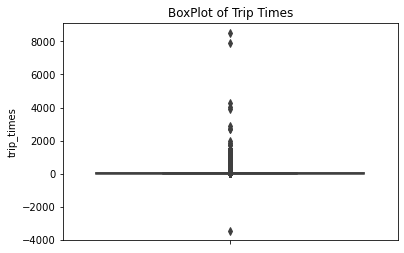

In [22]:
%matplotlib inline


# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data =frame_with_durations).set(title='BoxPlot of Trip Times')
plt.show()

In [23]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -3442.4
10 percentile value is 4.016666666666667
20 percentile value is 5.566666666666666
30 percentile value is 7.0
40 percentile value is 8.466666666666667
50 percentile value is 10.1
60 percentile value is 12.033333333333333
70 percentile value is 14.483333333333333
80 percentile value is 17.983333333333334
90 percentile value is 24.5
100 percentile value is  8513.183333333332


In [24]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 24.5
91 percentile value is 25.566666666666666
92 percentile value is 26.783333333333335
93 percentile value is 28.183333333333334
94 percentile value is 29.816666666666666
95 percentile value is 31.766666666666666
96 percentile value is 34.166666666666664
97 percentile value is 37.25
98 percentile value is 41.666666666666664
99 percentile value is 49.61666666666667
100 percentile value is  8513.183333333332


NY Authority rule the max travel is 12 hour=720min

In [25]:
frame_with_durations.shape

(2340367, 7)

In [26]:
nyc_taxi_Jan_2022.shape

(2340367, 19)

In [27]:
#removing data based on our analysis and TLC regulations

nyc_taxi_Jan_2022['trip_times'] = frame_with_durations['trip_times']
nyc_taxi_Jan_2022['pickup_times'] = frame_with_durations['pickup_times']
nyc_taxi_Jan_2022['Speed'] = frame_with_durations['Speed']

frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]
nyc_taxi_Jan_2022=nyc_taxi_Jan_2022[(nyc_taxi_Jan_2022.trip_times>1) & (nyc_taxi_Jan_2022.trip_times<720)]
#nyc_taxi_Jan_2022

In [28]:
nyc_taxi_Jan_2022.shape

(2311778, 22)

In [29]:
frame_with_durations_modified.shape

(2311778, 7)

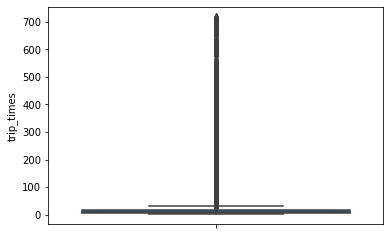

In [30]:
%matplotlib inline


#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =nyc_taxi_Jan_2022)
plt.show()

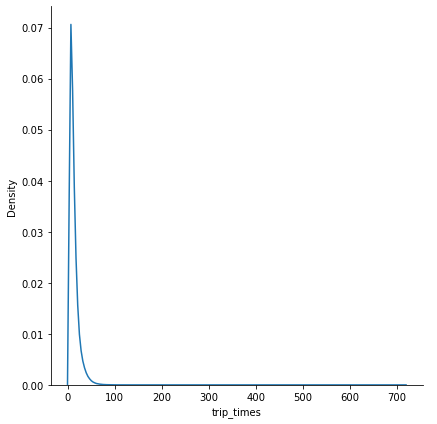

In [31]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(nyc_taxi_Jan_2022,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.show();

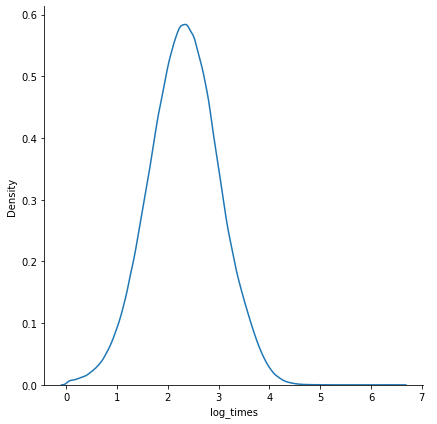

In [32]:
#converting the values to log-values to chec for log-normal
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

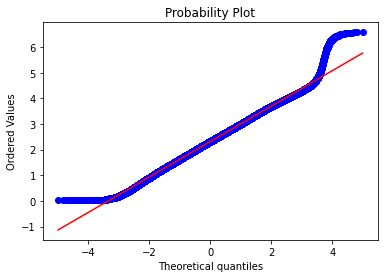

In [33]:
#Q-Q plot for checking if trip-times is log-normal
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

## 1.d. Speed

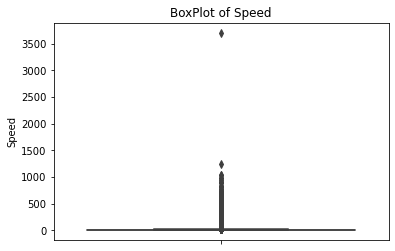

In [34]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified).set(title='BoxPlot of Speed')
plt.show()

In [35]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
#print("100 percentile value is ",var[-1])

#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.961832061068703
20 percentile value is 8.224299065420562
30 percentile value is 9.194366197183099
40 percentile value is 10.10888252148997
50 percentile value is 11.072509960159362
60 percentile value is 12.198636806231741
70 percentile value is 13.695104895104897
80 percentile value is 16.072892938496583
90 percentile value is 21.58730158730159
100 percentile value is  3701.5384615384614
90 percentile value is 21.58730158730159
91 percentile value is 22.57946370176586
92 percentile value is 23.677441306566855
93 percentile value is 24.913566113337147
94 percentile value is 26.324517512508933
95 percentile value is 27.9589216944801
96 percentile value is 29.838218053927317
97 percentile value is 32.0539629005059
98 percentile value is 34.81057268722466
99 percentile value is 38.674169949352844
99.0 percentile value is 38.674169949352844
99.1 percentile value is 39.18616480162767
99.2 percentile value is 39.755619596541784
99.3 percenti

In [36]:
#removing further outliers based on the 99.9th percentile value
#frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<48.25)]


nyc_taxi_Jan_2022=nyc_taxi_Jan_2022[(nyc_taxi_Jan_2022.Speed>0) & (nyc_taxi_Jan_2022.Speed<48.25)]

In [37]:
#avg.speed of cabs in New-York
sum(nyc_taxi_Jan_2022["Speed"]) / float(len(nyc_taxi_Jan_2022["Speed"]))

12.930126622008087

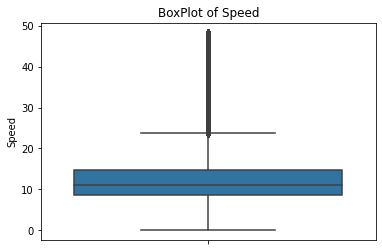

In [57]:
nyc_taxi_Jan_2022['Speed'] = 60*(nyc_taxi_Jan_2022['trip_distance']/nyc_taxi_Jan_2022['trip_times'])
sns.boxplot(y="Speed", data =nyc_taxi_Jan_2022).set(title='BoxPlot of Speed')
plt.show()

<b style='font-size:16px'>The avg speed in NewYork speed is 12.45miles/hr, so a cab driver can travel <font color='blue'> 2 miles per 10min on avg.</font> </b>

## 1.e. Payment Types:

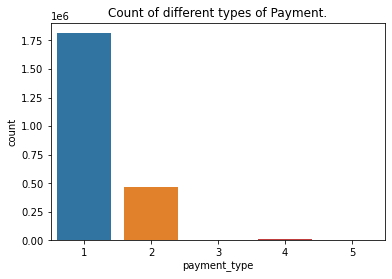

In [38]:
ax = sns.countplot(x="payment_type",data=nyc_taxi_Jan_2022).set(title='Count of different types of Payment.')

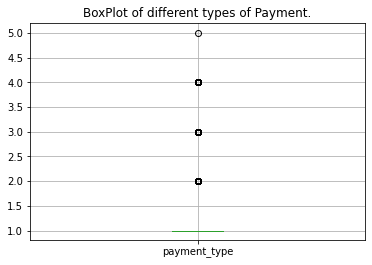

In [39]:
boxplot = nyc_taxi_Jan_2022.boxplot(column=['payment_type']).set(title='BoxPlot of different types of Payment.')

In [40]:
print("Least Payment Type:",nyc_taxi_Jan_2022['payment_type'].min())
print("Max Payment Type:",nyc_taxi_Jan_2022['payment_type'].max())

Least Payment Type: 1
Max Payment Type: 5


From the above observations, it seems there are no outliers. 

## 1.f. Total Amount

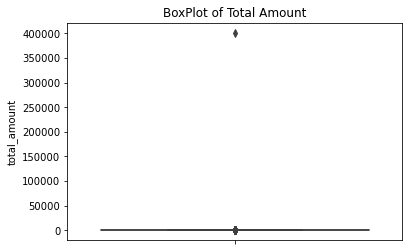

In [46]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =nyc_taxi_Jan_2022).set(title='BoxPlot of Total Amount')
plt.show()

In [42]:
display(min(nyc_taxi_Jan_2022['total_amount']))
display(max(nyc_taxi_Jan_2022['total_amount']))

-253.3

401095.62

In [43]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,10):
    var = nyc_taxi_Jan_2022["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))

for i in range(10,100,10):
    var = nyc_taxi_Jan_2022["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
#print("100 percentile value is ",var[-1])

#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = nyc_taxi_Jan_2022["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
#print("100 percentile value is ",var[-1])

for i in np.arange(0.0, 1.0, 0.1):
    var =nyc_taxi_Jan_2022["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -253.3
1 percentile value is 6.8
2 percentile value is 7.3
3 percentile value is 7.8
4 percentile value is 8.3
5 percentile value is 8.75
6 percentile value is 8.8
7 percentile value is 8.8
8 percentile value is 9.3
9 percentile value is 9.3
10 percentile value is 9.36
20 percentile value is 10.8
30 percentile value is 11.8
40 percentile value is 12.96
50 percentile value is 14.3
60 percentile value is 15.96
70 percentile value is 18.3
80 percentile value is 21.8
90 percentile value is 32.25
90 percentile value is 32.25
91 percentile value is 35.05
92 percentile value is 38.3
93 percentile value is 41.85
94 percentile value is 45.42
95 percentile value is 49.8
96 percentile value is 55.85
97 percentile value is 63.1
98 percentile value is 70.26
99 percentile value is 75.72
99.0 percentile value is 75.72
99.1 percentile value is 75.72
99.2 percentile value is 76.31
99.3 percentile value is 77.87
99.4 percentile value is 78.88
99.5 percentile value is 80.46
99.6 per

<b>Observation:-</b>

As for the 0th percentile, value is an outlier.

As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis

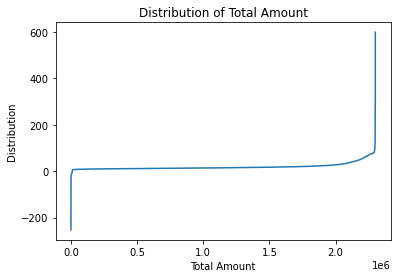

In [45]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.xlabel('Total Amount') 
plt.ylabel('Distribution') 
  
# displaying the title
plt.title("Distribution of Total Amount")
plt.show()

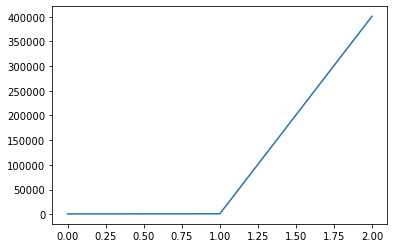

In [45]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

So removing the outliers.

In [46]:
nyc_taxi_Jan_2022[(nyc_taxi_Jan_2022['total_amount']<0) | (nyc_taxi_Jan_2022['total_amount']>1000)].count()

VendorID                 9826
tpep_pickup_datetime     9826
tpep_dropoff_datetime    9826
passenger_count          9826
trip_distance            9826
RatecodeID               9826
store_and_fwd_flag       9826
PULocationID             9826
DOLocationID             9826
payment_type             9826
fare_amount              9826
extra                    9826
mta_tax                  9826
tip_amount               9826
tolls_amount             9826
improvement_surcharge    9826
total_amount             9826
congestion_surcharge     9826
airport_fee              9826
trip_times               9826
pickup_times             9826
Speed                    9826
dtype: int64

In [47]:
nyc_taxi_Jan_2022.shape

(2299455, 22)

In [48]:
nyc_taxi_Jan_2022=nyc_taxi_Jan_2022[(nyc_taxi_Jan_2022['total_amount']>0) & (nyc_taxi_Jan_2022['total_amount']<1000)]

In [49]:
nyc_taxi_Jan_2022.shape

(2289580, 22)

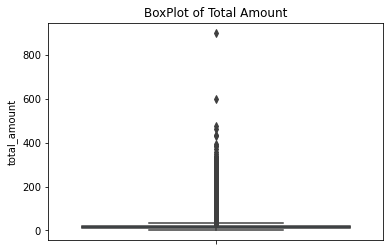

In [50]:
sns.boxplot(y="total_amount", data =nyc_taxi_Jan_2022).set(title='BoxPlot of Total Amount')
plt.show()

## 1.g. VendorID

As per NY Authority rule, there are only 2 Vendors. 

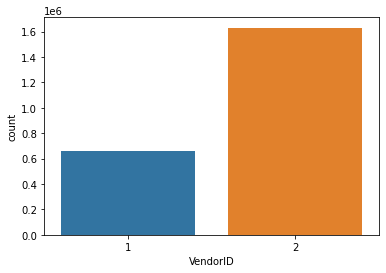

In [51]:
ax = sns.countplot(x="VendorID",data=nyc_taxi_Jan_2022)

From the above plot, there are no outliers.

## 1.h. PULocationID and DOLocationID

In [52]:
taxi_loc.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [54]:
taxi_loc['LocationID'].max()

265

By checking the taxi lookup, we can see that there are 265 NewYork Location Zones.

In [55]:
nyc_taxi_Jan_2022[(nyc_taxi_Jan_2022['PULocationID']<1) & (nyc_taxi_Jan_2022['PULocationID']>265)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_times,pickup_times,Speed


From the above observation, there are no outliers.

## 1.i. Pickup and Drop of Time:

In [58]:
nyc_taxi_Jan_2022['tpep_pickup_datetime'].min()

Timestamp('2008-12-31 23:03:01')

In [59]:
nyc_taxi_Jan_2022['tpep_dropoff_datetime'].max()

Timestamp('2022-05-18 20:47:45')

In [60]:
nyc_taxi_Jan_2022.shape

(2289580, 22)

In [61]:
2289580 - 2289550

30

In [62]:
indexAge = nyc_taxi_Jan_2022[(nyc_taxi_Jan_2022['tpep_pickup_datetime'] < '2022-01-01 00:00:00') ].index
nyc_taxi_Jan_2022.drop(indexAge , inplace=True)

In [63]:
indexAge = nyc_taxi_Jan_2022[nyc_taxi_Jan_2022['tpep_pickup_datetime'] > '2022-02-01 00:00:00'].index
nyc_taxi_Jan_2022.drop(indexAge , inplace=True)

In [64]:
nyc_taxi_Jan_2022.shape

(2289536, 22)

In [65]:
2289550 - 2289536

14

In [66]:
nyc_taxi_Jan_2022[nyc_taxi_Jan_2022['tpep_dropoff_datetime'] > '2022-02-01 12:00:00']

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_times,pickup_times,Speed


Now, we have a cleaned dataset. 

### We save this cleaned into new dataset.

In [63]:
nyc_taxi_Jan_2022.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_times,pickup_times,Speed
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,...,0.5,3.65,0.0,0.3,21.95,2.5,0.0,17.816667,1.641023e+09,12.797007
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,...,0.5,4.00,0.0,0.3,13.30,0.0,0.0,8.400000,1.641022e+09,15.000000
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,...,0.5,1.76,0.0,0.3,10.56,0.0,0.0,8.966667,1.641024e+09,6.490706
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,...,0.5,0.00,0.0,0.3,11.80,2.5,0.0,10.033333,1.641022e+09,6.518272
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,...,0.5,3.00,0.0,0.3,30.30,2.5,0.0,37.533333,1.641023e+09,6.873890


In [64]:
# save the data
output_dir = "D:/2_MS_in_DS/2nd_Semester/Machine_Learning/Project/Data/NYC_Taxi_Data/"
nyc_taxi_Jan_2022.to_csv(output_dir+"yellow_tripdata_2022-01_cleaned.csv")

In [68]:
nyc_taxi_Jan_2022.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
trip_times                      float64
pickup_times                    float64
Speed                           float64
WeekDay                          object
dtype: object

## 2. Weather Data

### Read the data

In [120]:
weather_data_Jan_2022 =  pd.read_csv(weather_input_dir+"weather_data_New_York_City_2022-01-01_2022-01-31.csv")

In [121]:
weather_data_Jan_2022.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"New York, NY, United States",2022-01-01T00:00:00,51.2,51.2,47.0,85.69,0.0,0,NaN,0.0,...,1012.7,100.0,7.6,NaN,NaN,NaN,NaN,Overcast,cloudy,"72505394728,KLGA,KNYC,72503014732"
1,"New York, NY, United States",2022-01-01T01:00:00,51.2,51.2,47.0,85.69,0.0,0,NaN,0.0,...,1012.5,100.0,7.2,NaN,NaN,NaN,NaN,Overcast,cloudy,"72505394728,KLGA,KNYC,72503014732"
2,"New York, NY, United States",2022-01-01T02:00:00,51.2,51.2,47.7,87.84,0.0,0,NaN,0.0,...,1012.6,100.0,6.3,NaN,NaN,NaN,NaN,Overcast,cloudy,"72505394728,KLGA,KNYC,72503014732"
3,"New York, NY, United States",2022-01-01T03:00:00,51.2,51.2,47.0,85.69,0.0,0,NaN,0.0,...,1012.2,100.0,8.2,NaN,NaN,NaN,NaN,Overcast,cloudy,"72505394728,KLGA,KNYC,72503014732"
4,"New York, NY, United States",2022-01-01T04:00:00,50.2,50.2,47.8,91.36,0.0,0,NaN,0.0,...,1011.2,100.0,7.1,NaN,NaN,NaN,NaN,Overcast,cloudy,"72505394728,KLGA,KNYC"


## 2.a. Check for Missing Values

In [122]:
nan_count  = pd.DataFrame()
nan_count['Count'] = weather_data_Jan_2022.isna().sum()

In [123]:
nan_count

,Count
name,0
datetime,0
temp,0
feelslike,0
dew,0
humidity,0
precip,0
precipprob,0
preciptype,657
snow,0


Text(0.5, 1.0, 'Number of Missing values in attributes before Column Selection')

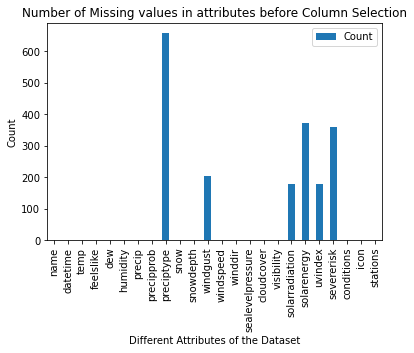

In [124]:
nan_count.plot(kind="bar")
plt.xlabel('Different Attributes of the Dataset') 
plt.ylabel('Count') 
plt.title("Number of Missing values in attributes before Column Selection")

### Selecting only the required columns. 

In [111]:
weather_data_Jan_2022.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"New York, NY, United States",2022-01-01T00:00:00,51.2,51.2,47.0,85.69,0.0,0,NaN,0.0,...,1012.7,100.0,7.6,NaN,NaN,NaN,NaN,Overcast,cloudy,"72505394728,KLGA,KNYC,72503014732"
1,"New York, NY, United States",2022-01-01T01:00:00,51.2,51.2,47.0,85.69,0.0,0,NaN,0.0,...,1012.5,100.0,7.2,NaN,NaN,NaN,NaN,Overcast,cloudy,"72505394728,KLGA,KNYC,72503014732"
2,"New York, NY, United States",2022-01-01T02:00:00,51.2,51.2,47.7,87.84,0.0,0,NaN,0.0,...,1012.6,100.0,6.3,NaN,NaN,NaN,NaN,Overcast,cloudy,"72505394728,KLGA,KNYC,72503014732"
3,"New York, NY, United States",2022-01-01T03:00:00,51.2,51.2,47.0,85.69,0.0,0,NaN,0.0,...,1012.2,100.0,8.2,NaN,NaN,NaN,NaN,Overcast,cloudy,"72505394728,KLGA,KNYC,72503014732"
4,"New York, NY, United States",2022-01-01T04:00:00,50.2,50.2,47.8,91.36,0.0,0,NaN,0.0,...,1011.2,100.0,7.1,NaN,NaN,NaN,NaN,Overcast,cloudy,"72505394728,KLGA,KNYC"


In [112]:
weather_data_Jan_2022.describe()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,539.000000,744.000000,744.000000,744.000000,744.000000,744.000000,564.000000,372.000000,564.000000,384.0
mean,30.904704,23.895296,16.331452,56.232312,0.005023,11.693548,0.008065,1.100121,18.143970,8.336290,206.821237,1018.061828,49.062903,8.833602,102.253546,0.558333,1.007092,10.0
std,9.934512,12.924533,14.116709,17.510298,0.022211,32.155957,0.044201,2.339522,7.570237,4.112742,121.015817,10.220504,40.968287,2.483615,155.744820,0.608883,1.608134,0.0
min,10.400000,-4.600000,-7.700000,27.270000,0.000000,0.000000,0.000000,0.000000,2.200000,0.000000,0.000000,984.900000,0.000000,0.200000,0.000000,0.000000,0.000000,10.0
25%,23.500000,15.575000,5.900000,42.652500,0.000000,0.000000,0.000000,0.000000,12.800000,5.500000,63.750000,1011.200000,13.400000,9.900000,0.000000,0.100000,0.000000,10.0
50%,30.500000,24.200000,14.000000,50.990000,0.000000,0.000000,0.000000,0.000000,19.000000,8.100000,240.000000,1018.350000,23.800000,9.900000,20.000000,0.300000,0.000000,10.0
75%,37.400000,32.025000,25.800000,66.947500,0.000000,0.000000,0.000000,0.010000,23.700000,11.125000,305.000000,1026.300000,100.000000,9.900000,139.250000,0.900000,1.000000,10.0
max,58.500000,58.500000,53.500000,95.860000,0.283000,100.000000,0.250000,9.060000,35.300000,21.900000,360.000000,1036.300000,100.000000,9.900000,583.000000,2.100000,6.000000,10.0


In [113]:
weather_data_Jan_2022.dtypes

name                 object
datetime             object
temp                float64
feelslike           float64
dew                 float64
humidity            float64
precip              float64
precipprob            int64
preciptype           object
snow                float64
snowdepth           float64
windgust            float64
windspeed           float64
winddir               int64
sealevelpressure    float64
cloudcover          float64
visibility          float64
solarradiation      float64
solarenergy         float64
uvindex             float64
severerisk          float64
conditions           object
icon                 object
stations             object
dtype: object

In [114]:
weather_data_Jan_2022.drop(['solarradiation','solarenergy','uvindex','severerisk','windgust','preciptype'], axis=1, inplace=True)

In [115]:
weather_data_Jan_2022.isna().sum()

name                0
datetime            0
temp                0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
snow                0
snowdepth           0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
conditions          0
icon                0
stations            0
dtype: int64

Text(0.5, 1.0, 'Number of Missing values in attributes after Column Selection')

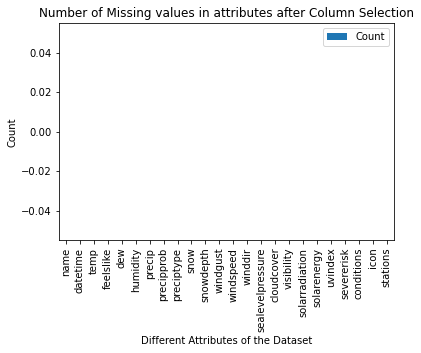

In [118]:
nan_count['Count'] = weather_data_Jan_2022.isna().sum()
nan_count.plot(kind="bar")
plt.xlabel('Different Attributes of the Dataset') 
plt.ylabel('Count') 
plt.title("Number of Missing values in attributes after Column Selection")

In [98]:
weather_data_Jan_2022.shape

(744, 18)

In [ ]:
from geopy.geocoders import Nominatim

In [ ]:
# Import the required library


# Initialize Nominatim API
geolocator = Nominatim(user_agent="MyApp")

location = geolocator.geocode("Riis Beach, New York")
print(location)
print("The latitude of the location is: ", location.latitude)
print("The longitude of the location is: ", location.longitude)

In [ ]:
nyc_taxi_Jan_2022[nyc_taxi_Jan_2022['passenger_count'].isnull()]

In [ ]:
nyc_taxi_Jan_2022.shape[0]

In [ ]:
#pip install gmplot
#!pip3 install geopy
!pip3 install folium

In [ ]:
import folium
map=folium.Map(location=[40.7128, 74.0060],zoom_start=15)
map.add_child(folium.Marker(location=[28.518580000000043,77.27589000000006],icon=folium.Icon(color='green')))
map

In [ ]:
import geopandas
import geoplot
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

store_locDF=pd.read_csv('stores.csv')
cols_to_keep=['store_longitude','store_latitude']

crs={'init':'epsg:4326'}

boroughs = geopandas.read_file(geoplot.datasets.get_path('nyc_boroughs'))

geo_df=geopandas.GeoDataFrame(store_locDF,crs=crs,geometry=geopandas.points_from_xy(store_locDF["store_longitude"], store_locDF["store_latitude"]))



fig,ax=plt.subplots(figsize=(15,15))
boroughs.plot(ax=ax,alpha=0.4,color="grey")
geo_df[geo_df['active_yn']=="Y"].plot(ax=ax,markersize=200, alpha=0.4,color="green", label="Active Store")
geo_df[geo_df['active_yn']=="N"].plot(ax=ax,markersize=200, alpha=0.4,color="red", label="Inactive Stores")
plt.legend()

In [ ]:
import gmplot
latitude_list = [30.3358376, 30.307977, 30.3216419, 30.3427904,
                  30.378598, 30.3548185, 30.3345816, 30.387299,
                    30.3272198, 30.3840597, 30.4158, 30.340426,
                             30.3984348, 30.3431313, 30.273471]
  
longitude_list = [77.8701919, 78.048457, 78.0413095, 77.886958,
                  77.825396, 77.8460573, 78.0537813, 78.090614,
                    78.0355272, 77.9311923, 77.9663, 77.952092,
                            78.0747887, 77.9555512, 77.9997158]
  
gmap4 = gmplot.GoogleMapPlotter.from_geocode("Dehradun, India")
  
# heatmap plot heating Type
# points on the Google map
gmap4.heatmap( latitude_list, longitude_list )
  
gmap4.draw( "C:\\Users\\user\\Desktop\\map14.html" )